# PLN - Pré-processamento de texto
Neste *notebook*, há diversas etapas utilizadas no pré-processamento do *corpus* DepreRedditBR. Para saber mais sobre as referências utilizadas no desenvolvimento deste fluxo, veja o arquivo `README.md`.

In [1]:
import pandas as pd

# Importar o corpus de um arquivo CSV
df = pd.read_csv('data/DepreRedditBR.csv')

# Flag utilizada para definir se a ferramenta Enelvo será utilizada ou não
USE_ENELVO = True
APPLY_LEMMATIZATION = True

# Obter o tamanho do dataset (linhas x colunas)
df.shape

(509669, 1)

## Exibir o dataframe

In [2]:
df.head() # Exibir as primeiras linhas do dataframe

,text
0,"Parece que ninguem quer ficar perto de mim, e,..."
1,"Eu sou deprimido, porem tem períodos que fico ..."
2,"Boa tarde. Bem, é basicamente um desabafo. A v..."
3,"Me tirem uma duvida, ser perfeccionista ao ac..."
4,"Oi gente, desculpa o textão, já mandei isso em..."


In [3]:
# Obter uma amostra do corpus (frac -> de 0 a 1)
df = df.sample(frac=0.01, random_state=42)

# Utilizando uma amostra pequena para testes
# df = df.sample(n=500, random_state=42)

# Obter a única coluna do dataframe: text
all_texts = df.text

Exibindo o conjunto de dados após a extração da única coluna em uma variável do tipo `pd.Series`.

In [4]:
all_texts

208601    não há nada que eu queira mais do que voltar n...
462528    Lidando com mudanças de humor Tenho tido muita...
76680     Se sua noiva não usar com voce, ja sabe. Não p...
359032    muitas vezes não consigo trabalhar cerca de um...
353889    quais são suas ações quando você está se senti...
                                ...                        
71960     Faz uma mistura de lidocaína e lubrificante me...
426392    tentando aconselhar um amigo próximo com doenç...
270923    não sei mais o que fazer, não sei mais o que f...
55606                           sim, vou pegar as inimigas?
505022    Tentei usar a música como uma forma de express...
Name: text, Length: 5097, dtype: object

## Opcional - Utilizano o Enelvo para normalizar aspectos do corpus
A normalização com Enelvo trata de aspectos como erros ortográficos, gírias, siglas e outros detalhes. A substituição das virgulas por uma *label* temporária é feita para contornar a ferramenta Enelvo, que separa números com vírgula durante a normalização.

Para este caso, utilizar o Enelvo demanda uma considerável quantidade de tempo, dado que os textos são densos e há uma grande quantidade de textos no *corpus* utilizado. Dessa maneira, utilizar-se-á apenas uma pequena amostra do conjunto de dados.

In [5]:
# Enelvo (https://thalesbertaglia.com/enelvo/)
from enelvo.normaliser import Normaliser

def replace_commas(texts: pd.Series) -> pd.Series:
    return texts.str.replace(r',', 'chavevirg')

def revert_replace_commas(texts: pd.Series) -> pd.Series:
    return texts.str.replace('chavevirg', ',')

def apply_enelvo_normalise(
        texts: pd.Series,
        normaliser_instance: Normaliser) -> pd.Series:
    return texts.apply(lambda text: normaliser_instance.normalise(text))

if USE_ENELVO:
    # Obter uma pequena amostra do corpus
    all_texts = all_texts.sample(n=20, random_state=1)
    print(f"\n----- TEXTOS ANTES DA NORMALIZAÇÃO -----\n\n{all_texts.values}")

    # Substituir as vírgulas pela label 'chavevirg' para evitar conflitos durante a normalização do texto
    all_texts = replace_commas(all_texts)

    # Aplicar a normalização com Enelvo para os textos do corpus
    all_texts = apply_enelvo_normalise(
        all_texts,
        Normaliser(tokenizer='readable')
    )

    print(f"\n----- TEXTOS DEPOIS DA NORMALIZAÇÃO -----\n\n{all_texts.values}")


----- TEXTOS ANTES DA NORMALIZAÇÃO -----

['me sinto desmotivada, triste e percebi comportamentos de automutilação'
 'preciso fazer algumas mudanças sérias, mas por onde começo? há tantas coisas ruins acontecendo na minha vida. em primeiro lugar, não estou escrevendo isso para sentir pena ou para tentar promover minha história triste. estou desesperado por ajuda e conselhos. é difícil não ser tão negativo quando há tantas coisas negativas acontecendo em sua vida. Tenho 22 anos e estive gravemente deprimido e fisicamente doente com problemas de saúde durante toda a minha vida adulta e até mesmo em alguns anos da minha adolescência. Tenho 2 pais abusivos com quem não falo muito e que não estão realmente dispostos a me ajudar, nem posso confiar neles para resolver meus problemas pessoais. então me sinto meio preso e sem esperança. meus problemas com meus pais e alguns dos abusos sofridos enquanto crescia me deram muitos problemas emocionais, além de tudo o mais que estou passando. tenho 

## Remoção de URLs
A remoção de URLs é uma etapa importante para reduzir o ruído do conjunto de dados e manter apenas palavras relevantes para o treinamento do modelo.

In [6]:
import re
# Remove URLs if there is any
all_texts = all_texts.apply(lambda text: re.sub(r'http\S+', '', text))

if USE_ENELVO:
    # Reverter a substituição de vírgulas
    all_texts = revert_replace_commas(all_texts)

all_texts

182970    me sinto desmotivada, triste e percebi comport...
248463    preciso fazer algumas mudanças sérias, mas por...
121206    neo não te acho babaca cometeu um erro na sua ...
353889    quais são suas ações quando você está se senti...
422230    o medo ansioso da morte está tirando minha vid...
196858    aleatoriedade, alguém já teve a sensação de qu...
358917    rompimentos e ansiedade, passei por um rompime...
452572    alguém pode me explicar a dissociação ? já ouv...
72989     talvez você esteja no lugar errado . antes de ...
322757    ( gatilho potencial ) ansiedade severa ao diri...
429903    preciso de conselhos sobre comentários feitos ...
321004    perdendo o controle por causa de contas médica...
101258    repergunta pra namorada dele o que ela acha so...
11973     na real isso foi um livramento pra você, não p...
168540    já estão pedindo o código fonte do voto impres...
56064     eu achava que incel, redil só existia na inter...
41681                       parabéns ! !

## Remoção de pontuação
A remoção de pontuação visa a redução do ruído (mantendo apenas as palavras que importam) e aumenta a eficiência do processamento.
É importante frisar que a pontuação **NÃO** é removida quando faz parte de *hashtags*, datas ou números com vírgula.

In [7]:
def remove_punctuation(text: str):
    return re.sub(
        r'(?<!\d),(?=\D)|(?<=\D),(?!\d)|(?<!\d),(?=\d)|(?<!\d)\/|\/(?!\d)|_|[^\w#\/\s,\@]','', text)

all_texts = all_texts.apply(lambda text: remove_punctuation(text))
all_texts.values

array(['me sinto desmotivada triste e percebi comportamentos de automutilação',
       'preciso fazer algumas mudanças sérias mas por onde começo  há tantas coisas ruins acontecendo na minha vida  em primeiro lugar não estou escrevendo isso para sentir pena ou para tentar promover minha história triste  estou desesperado por ajuda e conselhos  é difícil não ser tão negativo quando há tantas coisas negativas acontecendo em sua vida  tenho 22 anos e estive gravemente deprimido e fisicamente doente com problemas de saúde durante toda a minha vida adulta e até mesmo em alguns anos da minha adolescência  tenho 2 pais abusivos com quem não falo muito e que não estão realmente dispostos a me ajudar nem posso confiar neles para resolver meus problemas pessoais  então me sinto meio preso e sem esperança  meus problemas com meus pais e alguns dos abusos sofridos enquanto crescia me deram muitos problemas emocionais além de tudo o mais que estou passando  tenho lúpus asma outros problemas pulmona

## Tokenização do texto
Após a remoção de partes menos relevantes dos textos pertencentes ao *corpus*, é importante tokenizá-los, permitindo a aplicação de diversas técnicas, a exemplo da contagem de vocabulário. Além disso, facilita-se o processamento computacional do *corpus*.

In [8]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')
all_texts = all_texts.apply(lambda text: word_tokenize(text.lower()))
all_texts

[nltk_data] Downloading package punkt_tab to /home/yago/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


182970    [me, sinto, desmotivada, triste, e, percebi, c...
248463    [preciso, fazer, algumas, mudanças, sérias, ma...
121206    [neo, não, te, acho, babaca, cometeu, um, erro...
353889    [quais, são, suas, ações, quando, você, está, ...
422230    [o, medo, ansioso, da, morte, está, tirando, m...
196858    [aleatoriedade, alguém, já, teve, a, sensação,...
358917    [rompimentos, e, ansiedade, passei, por, um, r...
452572    [alguém, pode, me, explicar, a, dissociação, j...
72989     [talvez, você, esteja, no, lugar, errado, ante...
322757    [gatilho, potencial, ansiedade, severa, ao, di...
429903    [preciso, de, conselhos, sobre, comentários, f...
321004    [perdendo, o, controle, por, causa, de, contas...
101258    [repergunta, pra, namorada, dele, o, que, ela,...
11973     [na, real, isso, foi, um, livramento, pra, voc...
168540    [já, estão, pedindo, o, código, fonte, do, vot...
56064     [eu, achava, que, incel, redil, só, existia, n...
41681                          [parabéns

## Remoção de *stopwords*
É necessário remover palavras muito comuns no idioma, visto que, geralmente, elas trazem pouco significado semântico. Isso ajuda a **reduzir a dimensionalidade** e a aumentar a ênfase do vocabulário em **palavras mais importantes**.

Exemplos: artigos, preposições, conjunções, pronomes, advérbios de frequência e modo etc.

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')

def remove_stopwords(text: str):
    # Manter apenas as palavras que não esteja na lista de stopwords em Português
    words = [w for w in text if w not in stopwords.words('portuguese')]
    return words

all_texts = all_texts.apply(lambda text: remove_stopwords(text))
all_texts.head(10)

[nltk_data] Downloading package stopwords to /home/yago/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


182970    [sinto, desmotivada, triste, percebi, comporta...
248463    [preciso, fazer, algumas, mudanças, sérias, on...
121206    [neo, acho, babaca, cometeu, erro, cabeça, fra...
353889    [quais, ações, sentindo, ansioso, procurando, ...
422230    [medo, ansioso, morte, tirando, vida, assim, a...
196858    [aleatoriedade, alguém, sensação, dirige, vida...
358917    [rompimentos, ansiedade, passei, rompimento, j...
452572    [alguém, pode, explicar, dissociação, ouvi, te...
72989     [talvez, lugar, errado, antes, nada, sempre, v...
322757    [gatilho, potencial, ansiedade, severa, dirigi...
Name: text, dtype: object

## Lematização
Aplicar a lematização neste *corpus* é interessante para a redução do vocabulário, tendo em vista o grande número de palavras presentes no texto. Apesar disso, o tempo necessário para realizar esse processamento também é elevado, visto que é um processo complexo.

In [ ]:
import spacy
import spacy.cli

spacy.cli.download('pt_core_news_sm')
nlp = spacy.load('pt_core_news_sm')

def lemmatize_text(texts: pd.Series):
    docs = [nlp(text) for text in texts]
    lemmas = [token.lemma_ for doc in docs for token in doc]
    return lemmas

if APPLY_LEMMATIZATION:                                 
    all_texts = all_texts.apply(lemmatize_text)
    print(f"\n----- TEXTOS LEMATIZADOS -----\n\n{all_texts.values}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 28.7 MB/s eta 0:00:00m eta 0:00:010:01:01
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.

----- TEXTOS LEMATIZADOS -----

[list(['sinto', 'desmotivar', 'tristir', 'percebir', 'comportamento', 'automutilação'])
 list(['preciso', 'fazer', 'algum', 'mudança', 'sério', 'onde', 'começar', 'tanto', 'coisa', 'ruim', 'acontecer', 'vida', 'primeiro', 'lugar', 'escrever', 'sentir', 'pena', 'tentar', 'promover', 'história', 'tristir', 'desesperar', 'ajudar', 'conselho', 'difícil', 'tão', 'negativo', 'tanto', 'coisa', 'negativo', 'acontecer', 'vida', '22', 'ano', 'gravemente', 'deprimer', 'fisicamente', 'doente', 'problema', 'saúde', 'durante', 'todo', 'v

## Extração de *insights* a partir do *corpus*
Após as etapas de pré-processamento anteriormente aplicadas, é possível obter *insights* valiosos sobre o *corpus*.

In [11]:
# Obter a quantidade total de palavras para o corpus
def get_total_word_count(texts: pd.Series) -> int:
    total_word_count = 0
    for text in texts:
        total_word_count += len(text)
    return total_word_count

### Quantidade média de palavras por texto

In [12]:
avg_word_count = get_total_word_count(all_texts) / all_texts.shape[0]
print(f'Quantidade média de palavras por texto (aproximação): {round(avg_word_count)}')

Quantidade média de palavras por texto (aproximação): 55


### Nuvem de palavras

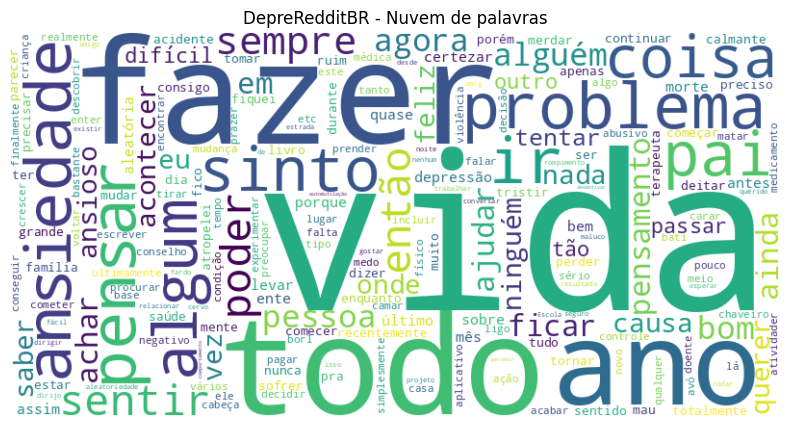

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_texts_joined = all_texts.apply(lambda text: ' '.join(text))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text for text in all_texts_joined))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('DepreRedditBR - Nuvem de palavras')
plt.show()